<a href="https://colab.research.google.com/github/zzanggyu/Pill-AI-Notification-System/blob/main/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 23.7 MB/s eta 0:00:00


In [ ]:
pip install tensorflow opencv-python

In [ ]:
# TensorFlow (일반적으로 Colab에 이미 설치되어 있습니다)
!pip install tensorflow

# OpenCV
!pip install opencv-python-headless

# scikit-learn
!pip install scikit-learn

# matplotlib
!pip install matplotlib

# tqdm
!pip install tqdm

# Pillow (PIL) - 이미지 처리용
!pip install Pillow

# (선택사항) 추가적인 데이터 처리 및 시각화 라이브러리
!pip install pandas seaborn

In [ ]:
# OpenCV
!pip install opencv-python-headless

# tqdm (진행 바 표시용)
!pip install tqdm

# scikit-learn (이미 설치되어 있을 가능성이 높지만, 확실히 하기 위해)
!pip install scikit-learn

# VGG 학습

In [ ]:
##################### 이걸로
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import json
import os
from sklearn.model_selection import train_test_split

# 모델 정의
def create_model():
    model = models.vgg16(weights='IMAGENET1K_V1')

    # 특징 추출 부분 고정
    for param in model.features.parameters():
        param.requires_grad = False

    # 분류기 부분 수정
    model.classifier[6] = nn.Linear(4096, 4)

    return model

# 데이터셋 클래스
class PillShapeDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
        self.shape_mapping = {
            "Circle": "원형",
            "Oblong": "장방형",
            "Oval": "타원형",
            "Octagon": "팔각형"
        }
        self.valid_shapes = list(self.shape_mapping.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')

        try:
            english_shape = self.data[idx]['regions'][0]['region_attributes']['shape']
            shape = self.shape_mapping.get(english_shape)
            if shape is None:
                print(f"알 수 없는 모양: {english_shape}, 파일: {img_name}")
                label = -1
            else:
                label = self.valid_shapes.index(shape)
        except (KeyError, IndexError):
            print(f"shape 정보 없음, 파일: {img_name}")
            label = -1

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터 로드 함수
def load_data(json_path, img_dir):
    # JSON 데이터 로드
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 데이터 처리
    processed_data = []
    for k, v in data['_via_img_metadata'].items():
        item = {'filename': v['filename'], 'regions': v.get('regions', [])}
        if item['regions']:
            processed_data.append(item)

    # 존재하는 파일만 필터링
    existing_files = set(os.listdir(img_dir))
    filtered_data = [item for item in processed_data if item['filename'] in existing_files]

    return filtered_data

# 학습 함수
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_valid = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum((preds == labels) & (labels != -1))
                total_valid += torch.sum(labels != -1)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / total_valid if total_valid > 0 else 0

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                }, '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_best.pth')

    return model

def main():
    # 경로 설정
    json_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/Merged_VGG_Learning_Data.json'
    img_dir = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/Pill_img'

    # 데이터 로드
    data = load_data(json_path, img_dir)
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    # 데이터 변환 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 데이터셋 생성
    train_dataset = PillShapeDataset(train_data, img_dir, transform=transform)
    val_dataset = PillShapeDataset(val_data, img_dir, transform=transform)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # 모델 생성
    model = create_model()
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    # 학습 실행
    trained_model = train_model(model, criterion, optimizer, train_loader, val_loader)

    # 최종 모델 저장
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_final.pth')

if __name__ == "__main__":
    main()

Epoch 1/25
----------
train Loss: 0.6055 Acc: 0.8156
val Loss: 0.2523 Acc: 0.9579
Epoch 2/25
----------
train Loss: 0.4135 Acc: 0.9402
val Loss: 0.1857 Acc: 0.9635
Epoch 3/25
----------
train Loss: 0.4064 Acc: 0.9514
val Loss: 0.7354 Acc: 0.9185
Epoch 4/25
----------
train Loss: 0.6593 Acc: 0.9444
val Loss: 0.2268 Acc: 0.9775
Epoch 5/25
----------
train Loss: 0.6357 Acc: 0.9620
val Loss: 0.2931 Acc: 0.9747
Epoch 6/25
----------
train Loss: 0.2639 Acc: 0.9782
val Loss: 0.0931 Acc: 0.9916
Epoch 7/25
----------
train Loss: 0.2880 Acc: 0.9824
val Loss: 0.6075 Acc: 0.9635
Epoch 8/25
----------
train Loss: 0.4481 Acc: 0.9831


KeyboardInterrupt: 

In [ ]:
## 팔각형 제외 학습 원형,타원형,장방형만 학습
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import json
import os
from sklearn.model_selection import train_test_split

# 모델 정의
def create_model():
    model = models.vgg16(weights='IMAGENET1K_V1')

    # 특징 추출 부분 고정
    for param in model.features.parameters():
        param.requires_grad = False

    # 분류기 부분 수정
    model.classifier[6] = nn.Linear(4096, 3)  # 3개의 클래스로 변경

    return model

# 데이터셋 클래스
class PillShapeDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
        self.shape_mapping = {
            "Circle": "원형",
            "Oblong": "장방형",
            "Oval": "타원형"
            # Octagon 제거
        }
        self.valid_shapes = list(self.shape_mapping.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')

        try:
            english_shape = self.data[idx]['regions'][0]['region_attributes']['shape']
            shape = self.shape_mapping.get(english_shape)
            if shape is None:
                print(f"알 수 없는 모양: {english_shape}, 파일: {img_name}")
                label = -1
            else:
                label = self.valid_shapes.index(shape)
        except (KeyError, IndexError):
            print(f"shape 정보 없음, 파일: {img_name}")
            label = -1

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터 로드 함수
def load_data(json_path, img_dir):
    # JSON 데이터 로드
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 데이터 처리 (팔각형 제외)
    processed_data = []
    valid_shapes = ["Circle", "Oblong", "Oval"]

    for k, v in data['_via_img_metadata'].items():
        if v.get('regions'):
            shape = v['regions'][0]['region_attributes'].get('shape')
            if shape in valid_shapes:
                processed_data.append({
                    'filename': v['filename'],
                    'regions': v['regions']
                })

    # 존재하는 파일만 필터링
    existing_files = set(os.listdir(img_dir))
    filtered_data = [item for item in processed_data if item['filename'] in existing_files]

    # 데이터 통계 출력
    print("데이터 통계:")
    shape_counts = {}
    for item in filtered_data:
        shape = item['regions'][0]['region_attributes']['shape']
        shape_counts[shape] = shape_counts.get(shape, 0) + 1

    print(f"총 데이터 수: {len(filtered_data)}")
    print("클래스별 데이터 수:")
    for shape, count in shape_counts.items():
        print(f"{shape}: {count}")

    return filtered_data

# 학습 함수
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_valid = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum((preds == labels) & (labels != -1))
                total_valid += torch.sum(labels != -1)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / total_valid if total_valid > 0 else 0

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                }, '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_3class_best.pth')

    return model

def main():
    # 경로 설정
    json_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/Merged_VGG_Learning_Data.json'
    img_dir = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/Pill_img'

    # 데이터 로드
    data = load_data(json_path, img_dir)
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    # 데이터 변환 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 데이터셋 생성
    train_dataset = PillShapeDataset(train_data, img_dir, transform=transform)
    val_dataset = PillShapeDataset(val_data, img_dir, transform=transform)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # 모델 생성
    model = create_model()
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    # 학습 실행
    trained_model = train_model(model, criterion, optimizer, train_loader, val_loader)

    # 최종 모델 저장
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_3class_final.pth')

if __name__ == "__main__":
    main()

데이터 통계:
총 데이터 수: 1333
클래스별 데이터 수:
Oval: 443
Oblong: 445
Circle: 445
Epoch 1/25
----------
train Loss: 0.6926 Acc: 0.7814
val Loss: 0.6218 Acc: 0.8951
Epoch 2/25
----------
train Loss: 0.1843 Acc: 0.9615
val Loss: 0.1630 Acc: 0.9700
Epoch 3/25
----------
train Loss: 0.3276 Acc: 0.9615
val Loss: 0.0564 Acc: 0.9888
Epoch 4/25
----------
train Loss: 0.1584 Acc: 0.9812
val Loss: 0.4492 Acc: 0.9625
Epoch 5/25
----------
train Loss: 0.2299 Acc: 0.9794
val Loss: 1.3139 Acc: 0.9700
Epoch 6/25
----------
train Loss: 0.7169 Acc: 0.9653
val Loss: 1.2516 Acc: 0.9700
Epoch 7/25
----------
train Loss: 0.3410 Acc: 0.9841
val Loss: 0.5951 Acc: 0.9775
Epoch 8/25
----------
train Loss: 0.3336 Acc: 0.9822
val Loss: 0.1877 Acc: 0.9888
Epoch 9/25
----------
train Loss: 0.6308 Acc: 0.9756
val Loss: 0.3784 Acc: 0.9888
Epoch 10/25
----------
train Loss: 0.5382 Acc: 0.9803
val Loss: 0.1977 Acc: 0.9888
Epoch 11/25
----------
train Loss: 0.0525 Acc: 0.9953
val Loss: 1.0794 Acc: 0.9775
Epoch 12/25
----------
train

KeyboardInterrupt: 

# vgg 테스트

In [ ]:
##################### 최종

import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import os

def create_model():
    model = models.vgg16(weights='IMAGENET1K_V1')

    # 분류기 부분 수정
    model.classifier[6] = nn.Linear(4096, 3)  # 3개의 클래스

    return model

def load_trained_model(model_path):
    # 모델 생성
    model = create_model()

    # GPU 사용 가능 여부 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 저장된 모델 불러오기
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # 모델을 평가 모드로 설정
    model.eval()
    model = model.to(device)

    return model, device

def predict_image(model, image_path, device):
    # 이미지 변환을 위한 전처리
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 클래스 레이블 정의
    classes = ["원형", "장방형", "타원형"]

    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # 예측
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

        # 각 클래스에 대한 확률 계산
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

    return {
        'predicted_class': classes[predicted.item()],
        'probabilities': {classes[i]: prob.item() for i, prob in enumerate(probabilities)}
    }

def test_model_on_directory(model_path, test_dir):
    # 모델 로드
    model, device = load_trained_model(model_path)

    # 테스트 디렉토리의 모든 이미지에 대해 예측 수행
    results = []

    for image_name in os.listdir(test_dir):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(test_dir, image_name)
            try:
                prediction = predict_image(model, image_path, device)
                results.append({
                    'image_name': image_name,
                    'prediction': prediction
                })
                print(f"\n이미지: {image_name}")
                print(f"예측된 클래스: {prediction['predicted_class']}")
                print("클래스별 확률:")
                for class_name, prob in prediction['probabilities'].items():
                    print(f"{class_name}: {prob:.4f}")
            except Exception as e:
                print(f"Error processing {image_name}: {str(e)}")

    return results

# 사용 예시
if __name__ == "__main__":
    # # 모델 경로와 테스트 이미지 디렉토리 설정
    # model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_3class_best.pth'
    # test_dir = '/content/drive/MyDrive/캡스톤 디자인 최종본/pillimgtest/realtest'

    # # 전체 테스트 디렉토리에 대한 테스트 실행
    # results = test_model_on_directory(model_path, test_dir)

    # 단일 이미지 테스트를 위한 예시
    model, device = load_trained_model(model_path)
    single_result = predict_image(model, '/content/drive/MyDrive/캡스톤 디자인 최종본/pillimgtest/손바닥/KakaoTalk_20241009_134400839_07.jpg', device)
    print(single_result)

{'predicted_class': '타원형', 'probabilities': {'원형': 0.0, '장방형': 0.0, '타원형': 1.0}}


In [ ]:
######
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
import cv2
import numpy as np
from ultralytics import YOLO

class PillDetectionClassification:
    def __init__(self, yolo_model_path, vgg_model_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # YOLO 모델 로드
        self.yolo_model = YOLO(yolo_model_path)

        # VGG 모델 로드
        self.vgg_model = self.create_vgg_model()
        checkpoint = torch.load(vgg_model_path, map_location=self.device)
        self.vgg_model.load_state_dict(checkpoint['model_state_dict'])
        self.vgg_model.eval()
        self.vgg_model = self.vgg_model.to(self.device)

        # Transform 정의
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.shape_classes = ["원형", "장방형", "타원형"]

    def create_vgg_model(self):
        model = models.vgg16(weights='IMAGENET1K_V1')
        model.classifier[6] = nn.Linear(4096, 3)
        return model

    def classify_pill_shape(self, image):
        # PIL Image로 변환
        if isinstance(image, np.ndarray):
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        elif not isinstance(image, Image.Image):
            raise ValueError("Unsupported image type")

        # 이미지 전처리
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 예측
        with torch.no_grad():
            outputs = self.vgg_model(image_tensor)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

        return {
            'predicted_class': self.shape_classes[predicted.item()],
            'probabilities': {
                self.shape_classes[i]: prob.item()
                for i, prob in enumerate(probabilities)
            }
        }

    def detect_and_classify_pills(self, image_path, conf_threshold=0.3):
        # 이미지 로드
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Could not load image at {image_path}")

        # 전체 이미지에 대한 형태 분류
        image_pil = Image.open(image_path).convert('RGB')
        shape_prediction = self.classify_pill_shape(image_pil)
        print(f"\nOverall image shape classification: {shape_prediction['predicted_class']}")
        print("Shape probabilities:", shape_prediction['probabilities'])

        # YOLO로 알약 위치 감지
        results = self.yolo_model.predict(image_path, conf=conf_threshold)

        detected_pills = []

        for result in results:
            boxes = result.boxes
            print(f"\nYOLO detected {len(boxes)} pills")

            for box in boxes:
                # 바운딩 박스 좌표
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                confidence = float(box.conf[0])

                # 결과 저장
                detected_pills.append({
                    'bbox': (x1, y1, x2, y2),
                    'confidence': confidence,
                    'shape': shape_prediction['predicted_class'],
                    'shape_probabilities': shape_prediction['probabilities']
                })

                # 결과 시각화
                cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"{shape_prediction['predicted_class']} ({confidence:.2f})"
                cv2.putText(original_image, label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        return original_image, detected_pills

def main():
    # 모델 경로 설정
    yolo_model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/Yolov8n/weights/best.pt'
    vgg_model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_3class_best.pth'

    # 테스트 이미지 경로
    image_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/pillimgtest/realtest/타이레놀1.jpg'

    try:
        # 모델 초기화
        detector = PillDetectionClassification(yolo_model_path, vgg_model_path)

        # 알약 감지 및 분류 실행
        result_image, detected_pills = detector.detect_and_classify_pills(image_path)

        print("\nDetection Results:")
        for i, pill in enumerate(detected_pills, 1):
            print(f"\nPill {i}:")
            print(f"Location: {pill['bbox']}")
            print(f"Detection confidence: {pill['confidence']:.4f}")
            print(f"Shape: {pill['shape']}")
            print("Shape probabilities:", pill['shape_probabilities'])

        # 결과 이미지 저장
        output_path = 'result.jpg'
        cv2.imwrite(output_path, result_image)
        print(f"\n결과 이미지가 {output_path}에 저장되었습니다.")

    except Exception as e:
        print(f"에러 발생: {str(e)}")

if __name__ == "__main__":
    main()


Overall image shape classification: 장방형
Shape probabilities: {'원형': 0.0, '장방형': 1.0, '타원형': 0.0}

image 1/1 /content/drive/MyDrive/캡스톤 디자인 최종본/pillimgtest/realtest/타이레놀1.jpg: 640x480 1 pill, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

YOLO detected 1 pills

Detection Results:

Pill 1:
Location: (918, 1773, 2081, 2540)
Detection confidence: 0.7895
Shape: 장방형
Shape probabilities: {'원형': 0.0, '장방형': 1.0, '타원형': 0.0}

결과 이미지가 result.jpg에 저장되었습니다.


모델 로딩 중...


<ipython-input-5-c79887bda120>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


모델이 cuda:0에 로드되었습니다.
테스트 데이터 로딩 중...
테스트 데이터 크기: 1779

테스트 세트 평가 중...
shape 정보 없음, 파일: 200400100_020.jpg

전체 정확도: 0.9989

클래스별 성능 지표:
              precision    recall  f1-score   support

          원형       1.00      1.00      1.00       445
         장방형       1.00      1.00      1.00       446
         타원형       1.00      1.00      1.00       443
         팔각형       1.00      1.00      1.00       444

    accuracy                           1.00      1778
   macro avg       1.00      1.00      1.00      1778
weighted avg       1.00      1.00      1.00      1778



/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54036 (\N{HANGUL SYLLABLE PAL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/s

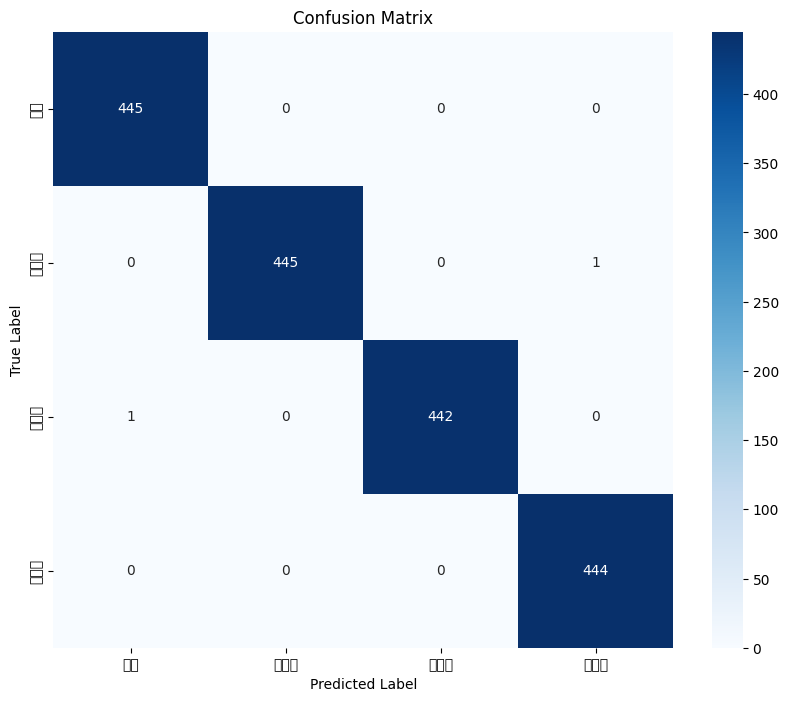


테스트 이미지 예측 결과: 원형


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import json
import os

# 데이터셋 클래스 정의
class PillShapeDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
        self.shape_mapping = {
            "Circle": "원형",
            "Oblong": "장방형",
            "Oval": "타원형",
            "Octagon": "팔각형"
        }
        self.valid_shapes = list(self.shape_mapping.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')

        try:
            english_shape = self.data[idx]['regions'][0]['region_attributes']['shape']
            shape = self.shape_mapping.get(english_shape)
            if shape is None:
                print(f"알 수 없는 모양: {english_shape}, 파일: {img_name}")
                label = -1
            else:
                label = self.valid_shapes.index(shape)
        except (KeyError, IndexError):
            print(f"shape 정보 없음, 파일: {img_name}")
            label = -1

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# JSON 데이터 로드
def load_json_data(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    processed_data = []
    for k, v in data['_via_img_metadata'].items():
        item = {'filename': v['filename'], 'regions': v.get('regions', [])}
        if item['regions']:
            processed_data.append(item)

    return processed_data

# VGG 모델 로드 및 설정
def load_model(model_path):
    model = models.vgg16(weights=None)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 4)

    checkpoint = torch.load(model_path)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    return model, device

# 평가 함수
def evaluate_dataset(model, test_loader, device):
    predictions = []
    actual = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # -1 레이블(잘못된 데이터)은 제외
            mask = labels != -1
            predictions.extend(preds[mask].cpu().numpy())
            actual.extend(labels[mask].cpu().numpy())

    return np.array(predictions), np.array(actual)

# 혼동 행렬 시각화
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 메인 평가 코드
def main():
    # 경로 설정
    model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier.pth'
    json_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/Merged_VGG_Learning_Data.json'
    img_dir = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/Pill_img'

    # 클래스 이름 정의
    classes = ["원형", "장방형", "타원형", "팔각형"]

    # 모델 로드
    print("모델 로딩 중...")
    model, device = load_model(model_path)
    print(f"모델이 {device}에 로드되었습니다.")

    # 테스트 데이터셋 로드
    print("테스트 데이터 로딩 중...")
    test_data = load_json_data(json_path)
    test_dataset = PillShapeDataset(test_data, img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    print(f"테스트 데이터 크기: {len(test_dataset)}")

    # 전체 데이터셋 평가
    print("\n테스트 세트 평가 중...")
    predictions, actual = evaluate_dataset(model, test_loader, device)

    # 평가 지표 계산 및 출력
    accuracy = accuracy_score(actual, predictions)
    print(f"\n전체 정확도: {accuracy:.4f}")

    print("\n클래스별 성능 지표:")
    print(classification_report(actual, predictions, target_names=classes))

    # 혼동 행렬 계산 및 시각화
    cm = confusion_matrix(actual, predictions)
    plot_confusion_matrix(cm, classes)

    # 단일 이미지 테스트
    test_image_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/pillimgtest/realtest/잘되는 거/글로게이트정1.jpg'
    if os.path.exists(test_image_path):
        image = Image.open(test_image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted = torch.max(outputs, 1)
            print(f"\n테스트 이미지 예측 결과: {classes[predicted.item()]}")

if __name__ == "__main__":
    main()

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 55.4 MB/s eta 0:00:00


In [ ]:
############### yolo로 좌표대로 잘라서 vgg에 넘겨 모양 예측 테스트
import torch
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import os
from ultralytics import YOLO

def create_model():
    model = models.vgg16(weights=None)
    # 분류기 부분 수정
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 4)
    return model

def detect_and_classify_pill(image_path, yolo_model_path, vgg_model_path):
    # YOLO 모델 로드
    yolo_model = YOLO(yolo_model_path)

    # VGG 모델 로드
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    vgg_model = create_model()
    checkpoint = torch.load(vgg_model_path)
    vgg_model.load_state_dict(checkpoint['model_state_dict'])
    vgg_model.to(device)
    vgg_model.eval()

    # 이미지 변환기
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 이미지 로드
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # YOLO로 알약 검출
    results = yolo_model(image_rgb)

    # 각 검출된 알약에 대해 처리
    detections = []

    for r in results:
        boxes = r.boxes
        for box in boxes:
            # 바운딩 박스 좌표 가져오기
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # 이미지 자르기
            cropped_img = image_rgb[y1:y2, x1:x2]

            # PIL Image로 변환
            pil_img = Image.fromarray(cropped_img)

            # 자른 이미지 저장 (디버깅용)
            debug_path = f'cropped_{len(detections)}.jpg'
            pil_img.save(debug_path)
            print(f"자른 이미지 저장됨: {debug_path}")

            # VGG 모델용으로 변환
            image_tensor = transform(pil_img).unsqueeze(0).to(device)

            # VGG로 모양 분류
            with torch.no_grad():
                outputs = vgg_model(image_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probabilities, 1)

                shapes = ["원형", "장방형", "타원형",]
                probs = probabilities[0].cpu().numpy()

                # 결과 저장
                detection = {
                    'box': (x1, y1, x2, y2),
                    'shape': shapes[predicted.item()],
                    'confidence': confidence.item(),
                    'probabilities': {shape: float(prob) for shape, prob in zip(shapes, probs)}
                }
                detections.append(detection)

                # 결과 출력
                print(f"\n검출된 알약 {len(detections)}:")
                print(f"위치: ({x1}, {y1}, {x2}, {y2})")
                print("\n각 클래스별 확률:")
                for shape, prob in zip(shapes, probs):
                    print(f"{shape}: {prob:.4f}")
                print(f"\n예측된 모양: {shapes[predicted.item()]}")
                print(f"신뢰도: {confidence.item():.2%}")
                print("-" * 50)

    # 결과 시각화
    image_with_boxes = image_rgb.copy()
    for det in detections:
        x1, y1, x2, y2 = det['box']
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{det['shape']} ({det['confidence']:.2%})"
        cv2.putText(image_with_boxes, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # 결과 이미지 저장
    result_path = 'result.jpg'
    cv2.imwrite(result_path, cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR))
    print(f"\n결과 이미지 저장됨: {result_path}")

    return detections

# 테스트 실행
def main():
    # 모델 경로
    yolo_model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/Yolov8n/weights/best.pt'
    vgg_model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_3class_best.pth'

    # 테스트 이미지
    image_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/Pill_img/200400173_003.jpg'

    print("알약 검출 및 분류 시작...")
    detections = detect_and_classify_pill(image_path, yolo_model_path, vgg_model_path)

    print(f"\n총 {len(detections)}개의 알약이 검출되었습니다.")

if __name__ == "__main__":
    import torch.nn as nn
    from torchvision import models
    main()

알약 검출 및 분류 시작...


RuntimeError: Error(s) in loading state_dict for VGG:
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([3, 4096]) from checkpoint, the shape in current model is torch.Size([4, 4096]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([4]).

In [ ]:
## 이거다 ㅅㅂ

import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
import cv2
import numpy as np
from ultralytics import YOLO

class PillDetectionClassification:
    def __init__(self, yolo_model_path, vgg_model_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # YOLO 모델 로드
        self.yolo_model = YOLO(yolo_model_path)

        # VGG 모델 로드 - 기존 코드와 동일한 방식 사용
        self.vgg_model = self.create_vgg_model()
        checkpoint = torch.load(vgg_model_path, map_location=self.device)
        self.vgg_model.load_state_dict(checkpoint['model_state_dict'])
        self.vgg_model.eval()
        self.vgg_model = self.vgg_model.to(self.device)

        # 기존 코드와 동일한 transform 사용
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.shape_classes = ["원형", "장방형", "타원형"]

    def create_vgg_model(self):
        model = models.vgg16(weights='IMAGENET1K_V1')
        model.classifier[6] = nn.Linear(4096, 3)
        return model

    def classify_pill_shape(self, pill_image):
        # PIL Image로 변환 확실히 하기
        if isinstance(pill_image, np.ndarray):
            pill_image = Image.fromarray(cv2.cvtColor(pill_image, cv2.COLOR_BGR2RGB))
        elif not isinstance(pill_image, Image.Image):
            raise ValueError("Unsupported image type")

        # 기존 코드와 동일한 전처리 방식 사용
        image_tensor = self.transform(pill_image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.vgg_model(image_tensor)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

        return {
            'predicted_class': self.shape_classes[predicted.item()],
            'probabilities': {
                self.shape_classes[i]: prob.item()
                for i, prob in enumerate(probabilities)
            }
        }

    def detect_and_classify_pills(self, image_path, conf_threshold=0.3):
        # 원본 이미지 로드
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Could not load image at {image_path}")

        # YOLO로 알약 감지
        results = self.yolo_model.predict(image_path, conf=conf_threshold)

        detected_pills = []

        # 디버깅을 위한 출력 추가
        print(f"YOLO detected {len(results[0].boxes)} objects")

        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                confidence = float(box.conf[0])

                # 잘라낸 이미지 확인
                pill_image = original_image[y1:y2, x1:x2]
                if pill_image.size == 0:
                    print(f"Warning: Empty crop at coordinates: ({x1}, {y1}, {x2}, {y2})")
                    continue

                # 디버깅을 위한 출력
                print(f"Processing crop of size: {pill_image.shape}")

                # PIL Image로 변환
                pill_image_rgb = cv2.cvtColor(pill_image, cv2.COLOR_BGR2RGB)
                pill_image_pil = Image.fromarray(pill_image_rgb)

                try:
                    # VGG 모델로 분류
                    shape_prediction = self.classify_pill_shape(pill_image_pil)

                    # 결과 저장
                    detected_pills.append({
                        'bbox': (x1, y1, x2, y2),
                        'confidence': confidence,
                        'shape': shape_prediction['predicted_class'],
                        'shape_probabilities': shape_prediction['probabilities']
                    })

                    # 결과 표시
                    cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    label = f"{shape_prediction['predicted_class']} ({confidence:.2f})"
                    cv2.putText(original_image, label, (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    # 디버깅을 위한 출력
                    print(f"Successfully classified pill: {shape_prediction['predicted_class']}")

                except Exception as e:
                    print(f"Error processing crop: {str(e)}")
                    continue

        return original_image, detected_pills

def main():
    # 테스트용 함수
    def test_single_image(detector, image_path):
        # 원본 이미지로 직접 VGG 테스트 (YOLO 없이)
        image = Image.open(image_path).convert('RGB')
        direct_prediction = detector.classify_pill_shape(image)
        print("\nDirect VGG prediction (without YOLO):")
        print(direct_prediction)

        # YOLO + VGG 파이프라인 테스트
        result_image, detected_pills = detector.detect_and_classify_pills(image_path)
        print("\nYOLO + VGG pipeline results:")
        for pill in detected_pills:
            print(f"Shape: {pill['shape']}")
            print(f"Confidence: {pill['confidence']:.4f}")
            print("Probabilities:", pill['shape_probabilities'])

        return result_image, detected_pills

    # 모델 경로 설정
    yolo_model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/Yolov8n/weights/best.pt'
    vgg_model_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/vgg/pill_shape_classifier_3class_best.pth'

    # 모델 초기화
    detector = PillDetectionClassification(yolo_model_path, vgg_model_path)

    # 테스트 이미지
    image_path = '/content/drive/MyDrive/캡스톤 디자인 최종본/pillimgtest/realtest/뮤테란캡슐1.jpg'

    try:
        result_image, detected_pills = test_single_image(detector, image_path)

        # 결과 이미지 저장
        output_path = 'result.jpg'
        cv2.imwrite(output_path, result_image)
        print(f"\n결과 이미지가 {output_path}에 저장되었습니다.")

    except Exception as e:
        print(f"에러 발생: {str(e)}")

if __name__ == "__main__":
    main()


Direct VGG prediction (without YOLO):
{'predicted_class': '장방형', 'probabilities': {'원형': 0.0, '장방형': 1.0, '타원형': 0.0}}

image 1/1 /content/drive/MyDrive/캡스톤 디자인 최종본/pillimgtest/realtest/뮤테란캡슐1.jpg: 640x480 1 pill, 8.1ms
Speed: 3.8ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
YOLO detected 1 objects
Processing crop of size: (743, 1148, 3)
Successfully classified pill: 타원형

YOLO + VGG pipeline results:
Shape: 타원형
Confidence: 0.7530
Probabilities: {'원형': 0.0, '장방형': 0.0, '타원형': 1.0}

결과 이미지가 result.jpg에 저장되었습니다.
